In [1]:
import IPython
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torchaudio
import h5py
import librosa
from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import os, sys, glob

# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

os.makedirs("/kaggle/temp", exist_ok=True)

In [2]:
class AudioFrontendConfig:
    sample_rate = 16000
    stft_hop_length = 0.010
    stft_win_length = 0.030
    num_mels = 80
    fmin = 50
    fmax = 7600

    def n_fft(self):
        return int(0.5 + self.sample_rate * self.stft_win_length)

class AudioFrontend:
    def __init__(self, config):
        self.config = config
        self.n_fft = int(0.5 + config.sample_rate * config.stft_win_length)
        self.hop_length = int(0.5 + config.sample_rate * config.stft_hop_length)
        
    def encode(self, wave, sr):
        if sr != self.config.sample_rate:
            wave = librosa.resample(wave, orig_sr=sr, target_sr=self.config.sample_rate)
        D = np.abs(librosa.stft(wave, n_fft=self.n_fft, hop_length=self.hop_length))
        M = librosa.feature.melspectrogram(S=D, sr=self.config.sample_rate, n_mels=self.config.num_mels, 
                                           power=1, norm=2, fmin=self.config.fmin, fmax=self.config.fmax)
        D_db = librosa.amplitude_to_db(D)
        M_db = librosa.amplitude_to_db(M)
        return D_db, M_db
    def decode(self, D_db):
        D = librosa.db_to_amplitude(D_db)
        return librosa.griffinlim(D, hop_length=self.hop_length), self.config.sample_rate
    def mel_inv(self, M_db):
        M = librosa.db_to_amplitude(M_db)
        D = librosa.feature.inverse.mel_to_stft(M, sr=self.config.sample_rate, n_fft=self.n_fft, 
                                                power=1, norm=2, fmin=self.config.fmin, fmax=self.config.fmax)
        return librosa.amplitude_to_db(D)

class TranscribedAudioDataset(torch.utils.data.Dataset):
    def __init__(self, transcript_path, file_fn=None):
        if file_fn is None:
            file_fn = lambda x: x
        ds_dir = os.path.split(transcript_path)[0]
        with open(transcript_path) as text_file:
            lines_split = [line.strip().split('|')[:2] for line in text_file.readlines()]
            self.transcripts = [(file_id, transcript, os.path.join(ds_dir, file_fn(file_id))) for file_id, transcript in lines_split]
    
    def __len__(self):
        return 1200 # len(self.transcripts)
    
    def __getitem__(self, index):
        utt_id, transcript, audio_path = self.transcripts[index]
        audio, sr = librosa.load(audio_path, sr=None)
        return utt_id, transcript, audio, sr
    
class MelDataset(torch.utils.data.Dataset):
    def __init__(self, audio_dataset, audio_frontend):
        self.ds = audio_dataset
        self.af = audio_frontend
        self.fs = h5py.File('/kaggle/temp/meldataset.hdf5', 'a')

    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        utt_id, transcript, audio, sr = self.ds[index]
        if utt_id in self.fs:
            D_db = self.fs.get(f'{utt_id}/stft')[()]
            M_db = self.fs.get(f'{utt_id}/mel')[()]
        else:
            D_db, M_db = self.af.encode(audio, sr)
            self.fs.create_dataset(f'{utt_id}/stft', data=D_db)
            self.fs.create_dataset(f'{utt_id}/mel', data=M_db)
        D_db[0:2, :] = -50
        return transcript, D_db, M_db

Dataset size: 1200 entries
In de provincie Overijssel wonen relatief veel mensen.
(241, 355) -50.0 30.371677
(80, 355) -48.113575 31.886425


(80, 15501)
sigma(M) = 0.994, mu(M) = 0.000


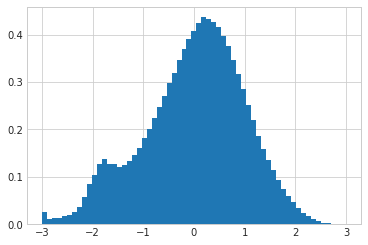

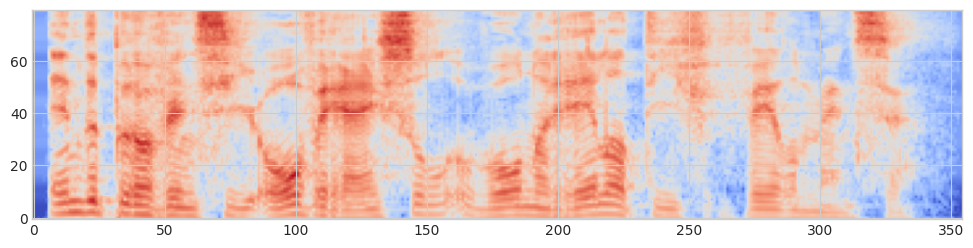

In [3]:
audio_frontend = AudioFrontend(AudioFrontendConfig())
dataset = MelDataset(TranscribedAudioDataset('/kaggle/input/spoken-belgian-dutch-audio/RDH_VL/transcripts.txt', 
                                             file_fn = lambda x: x + '.wav'), 
                     audio_frontend)
# dataset = TranscribedAudioDataset('/kaggle/input/dutch-single-speaker-speech-dataset/transcript.txt')
print(f'Dataset size: {len(dataset)} entries')

transcript, D_db, M_db = dataset[25]
print(transcript)
print(D_db.shape, np.min(D_db), np.max(D_db))
print(M_db.shape, np.min(M_db), np.max(M_db))
audio_decoded, _ = audio_frontend.decode(D_db)
IPython.display.display(IPython.display.Audio(audio_decoded, rate=audio_frontend.config.sample_rate))
audio_decoded_mel, _ = audio_frontend.decode(audio_frontend.mel_inv(M_db))
IPython.display.display(IPython.display.Audio(audio_decoded_mel, rate=audio_frontend.config.sample_rate))

D_db_sample = np.concatenate([dataset[i][1] for i in range(50)], axis=1)
M_db_sample = np.concatenate([dataset[i][2] for i in range(50)], axis=1)
print(M_db_sample.shape)

# plt.figure(figsize=(12,4), dpi=100)
# plt.subplot(121)
# plt.plot(np.std(M_db_sample, axis=1))
# plt.plot(np.mean(M_db_sample, axis=1))

D_db_avg = np.expand_dims(np.mean(D_db_sample, axis=1), axis=1)
M_db_avg = np.expand_dims(np.mean(M_db_sample, axis=1), axis=1)

def m_fwd(x):
    return np.clip((x - M_db_avg) / 15, -3, 3)

def m_rev(x):
    return np.clip(x, -3, 3) * 15 + M_db_avg

def d_fwd(x):
    return np.clip((x - D_db_avg) / 15, -3, 3)

def d_rev(x):
    return np.clip(x, -3, 3) * 15 + D_db_avg

x = m_fwd(M_db_sample)
print(f'sigma(M) = {np.std(x.flatten()):.3f}, mu(M) = {np.mean(x.flatten()):.3f}')

# plt.subplot(122)
plt.hist(x.flatten(), bins=61, density=True)
# plt.show()

plt.figure(figsize=(12,4), dpi=100)
plt.imshow(m_fwd(M_db), origin='lower', cmap='coolwarm')
# plt.figure(figsize=(12,6), dpi=100)
# plt.imshow(d_fwd(D_db), origin='lower', cmap='coolwarm')

In [4]:
for i in tqdm(range(len(dataset))):
    dataset[i]
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 200, 200], 
                                                            generator=torch.Generator().manual_seed(42))

  0%|          | 0/1200 [00:00<?, ?it/s]

In [5]:
class HighwayLayer(nn.Module):
    def __init__(self, dim_input, dim_output, activation=nn.functional.relu):
        super().__init__()
        self.H = nn.Linear(dim_input, dim_output)
        self.T = nn.Linear(dim_input, dim_output)
        self.R = nn.Linear(dim_input, dim_output) if dim_input != dim_output else nn.Identity()
        self.activation = activation
    
    def forward(self, x):
        t = torch.sigmoid(self.T(x))
        y = self.activation(self.H(x))
        r = self.R(x)
        return (y * t) + (r * (1 - t))


class CBHG(nn.Module):
    def __init__(self, dim_input, dim_output, dim_rnn=256, dim_conv_hidden=128, dim_proj_hidden=128, dim_highway=128, K=16):
        super().__init__()
        self.conv_bank = nn.ModuleList([
            nn.Sequential(
            nn.Conv1d(dim_input, dim_conv_hidden, kernel_size=k, padding=k//2, bias=False),
            nn.BatchNorm1d(dim_conv_hidden),
            nn.ReLU()
            ) for k in range(1, 1+K, 2)])
        self.max_pool = nn.MaxPool1d(kernel_size=3, stride=1, padding=1)
        self.conv_proj = nn.Sequential(
            nn.Conv1d(len(self.conv_bank)*dim_conv_hidden, dim_proj_hidden, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(dim_proj_hidden),
            nn.ReLU(),
            nn.Conv1d(dim_proj_hidden, dim_input, kernel_size=3, padding=1),
            # nn.BatchNorm1d(dim_input),
        )
        self.highway = nn.Sequential(
            nn.Linear(dim_input, dim_highway, bias=False),
            HighwayLayer(dim_highway, nn.functional.relu),
            HighwayLayer(dim_highway, nn.functional.relu),
        )
        self.rnn = nn.GRU(input_size=dim_highway, hidden_size=(dim_rnn//2), bidirectional=True, batch_first=True)
        self.fc = nn.Linear(dim_rnn, dim_output, bias=False)
        self.rnn.flatten_parameters() 

    def forward(self, x):
        x_residual = x          # B x T x D_in
        x = x.transpose(1, 2)   # B x D_in x T
        x = [conv(x) for conv in self.conv_bank] # [B x D_conv_h x T]
        x = torch.cat(x, dim=1) # B x K*D_conv_h x T
        x = self.max_pool(x)    # B x K*D_in x T
        x = self.conv_proj(x).transpose(1, 2)    # B x T x D_in
        x = x + x_residual      # B x T x D_in
        x = self.highway(x)     # B x T x D_highway
        x, _ = self.rnn(x)      # B x T x D_rnn
        return self.fc(x)       # B x T x D_out

    
class PostNet(nn.Module):
    def __init__(self, dim_mel, dim_stft):
        super().__init__()
        self.cbhg = CBHG(dim_mel, dim_stft, dim_conv_hidden=64, dim_proj_hidden=128, K=8)
        self.direct = nn.Linear(dim_mel, dim_stft) #, bias=False)
        self.nonlinear = nn.Sequential(
#             nn.Linear(dim_mel, dim_mel),
#             nn.Tanh(),
            nn.Linear(dim_mel, dim_stft),
            nn.Tanh(),
            HighwayLayer(dim_stft, torch.tanh),
            HighwayLayer(dim_stft, torch.tanh),
            nn.Linear(dim_stft, dim_stft, bias=False),
        )
        
    def forward(self, x):
        # return self.cbhg(x) + self.direct(x)
        return self.cbhg(x) + self.direct(x) + self.nonlinear(x)

class Transpose12(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.transpose(1, 2)
    
class PostNet2(nn.Module):
    def __init__(self, n_mels, n_fft):
        super().__init__()
        n_rnn = 320
        K1, K2 = 7, 7 # Mels x Time
        C = 20
        self.conv = nn.Sequential(
            nn.Conv2d(1, C, kernel_size=(K1, K2), padding=((K1-1)//2, (K2-1)//2)), # (N,Cin,H,W) -> (N,Cout,Hout,Wout)
            nn.Tanh(),
#             nn.BatchNorm2d(C),
#             nn.Conv2d(C, C, kernel_size=(K1, K2), padding=((K1-1)//2, (K2-1)//2)), # (N,Cin,H,W) -> (N,Cout,Hout,Wout)
#             nn.Tanh(),
#             nn.BatchNorm2d(C),
        )
        self.rnn = nn.LSTM(input_size=C*n_mels, hidden_size=n_rnn, batch_first=True, bidirectional=False, num_layers=1)
        self.rnn_fc = nn.Sequential(
            HighwayLayer(n_rnn, n_rnn),
            nn.Linear(n_rnn, n_fft, bias=True)
        )
#         self.linear_direct = nn.Linear(n_mels, n_fft)
#         self.nonlinear_direct = nn.Sequential(
#             HighwayLayer(n_mels, n_fft, torch.tanh),
#             HighwayLayer(n_fft, n_fft, torch.tanh),            
#             nn.Linear(n_fft, n_fft, bias=False)
#         )
        self.rnn.flatten_parameters()

    def forward(self, x):
        # Input: B x T x n_mels
#         y = self.linear_direct(x)          # B x T x n_fft
#         z = self.nonlinear_direct(x)
        x = x.transpose(1, 2).unsqueeze(1) # B x 1 x n_mels x T
        x = self.conv(x).flatten(1, 2)     # B x (C*n_mels) x T
        x = x.transpose(1, 2)              # B x T x (C*n_mels)
        x = self.rnn(x)[0]
        x = self.rnn_fc(x)           # B x T x n_fft
        return x # (x + y + z)

In [6]:
def collate_fn(x):
    lens = [len(M_db.T) for _, _, M_db in x]
    mask = [torch.from_numpy(np.ones((x, 1))) for x in lens]
    mask = torch.nn.utils.rnn.pad_sequence(mask, batch_first=True)
    M_db = [torch.from_numpy(m_fwd(M_db).T) for _, _, M_db in x]
    M_db = torch.nn.utils.rnn.pad_sequence(M_db, batch_first=True)
    D_db = [torch.from_numpy(d_fwd(D_db).T) for _, D_db, _ in x]
    D_db = torch.nn.utils.rnn.pad_sequence(D_db, batch_first=True)
#     print('Collate', M_db.shape, D_db.shape, mask.shape)
    return [M_db, D_db, mask] # M_db, D_db, mask

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = PostNet2(80, 241)
# model = PostNet(80, 241)
print(f"Model structure: {model}")

model2 = model if device == 'cpu' else nn.DataParallel(model)
optimizer = torch.optim.AdamW(model2.parameters(), lr=0.002, amsgrad=True, weight_decay=0.01)

Using cuda device
Model structure: PostNet2(
  (conv): Sequential(
    (0): Conv2d(1, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): Tanh()
  )
  (rnn): LSTM(1600, 320, batch_first=True)
  (rnn_fc): Sequential(
    (0): HighwayLayer(
      (H): Linear(in_features=320, out_features=320, bias=True)
      (T): Linear(in_features=320, out_features=320, bias=True)
      (R): Identity()
    )
    (1): Linear(in_features=320, out_features=241, bias=True)
  )
)


In [7]:
def loss_fn(outputs, labels, mask):
    loss = (outputs - labels).abs()**2 * mask # nn.functional.l1_loss(outputs, labels, reduction='none') * mask
    loss = loss.sum(dim=(1,2)) / (mask.sum(dim=(1,2)) * outputs.size(-1))
    return 15 * (loss.mean()**0.5) # + loss.max()) / 2

def loss_loop(model, loss_fn, loader, optimizer=None):
    if optimizer is not None: model.train()
    else: model.eval()
    loss_hist = []
    for batch_idx, batch in enumerate(loader):
        inputs, labels, mask = [x.to(device) for x in batch]
        if optimizer is not None:
            optimizer.zero_grad()
        outputs = model(inputs) # [0]
        loss = loss_fn(outputs, labels, mask)
        if optimizer is not None:
            loss.backward()
            optimizer.step()
        loss_hist.append(loss.item())
    return loss_hist

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, collate_fn=collate_fn, batch_size=200, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, collate_fn=collate_fn, batch_size=200, pin_memory=True)

model2.to(device)

pbar = tqdm(range(400))
loss_hist = []
for epoch_idx in pbar:
    epoch_loss = loss_loop(model2, loss_fn, train_loader, optimizer)
    epoch_test_loss = loss_loop(model2, loss_fn, test_loader, None)
    pbar.set_postfix_str(f"Loss: {np.mean(epoch_loss):.2f} dB, Test: {np.mean(epoch_test_loss):.2f} dB")
    loss_hist.append([np.mean(epoch_loss), np.mean(epoch_test_loss)])

model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/kaggle/working/model_scripted.pt') # Save

  0%|          | 0/400 [00:00<?, ?it/s]

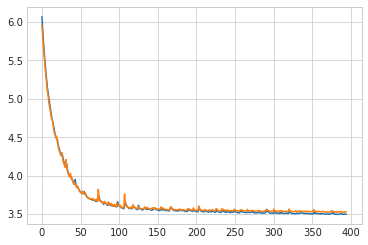

Het vliegtuig vloog zo laag dat het zelfs nipt de toppen van sommige bomen raakte.
(241, 424) (241, 424) -59.535976 27.10949
std(err) = 3.57 dB
mu(abs(err)) = 2.40 dB


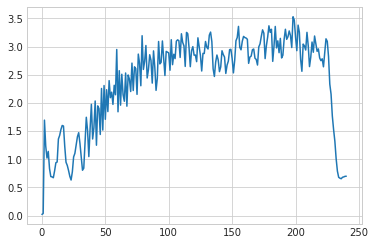

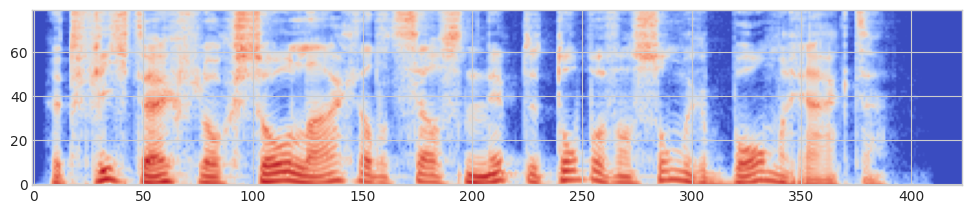

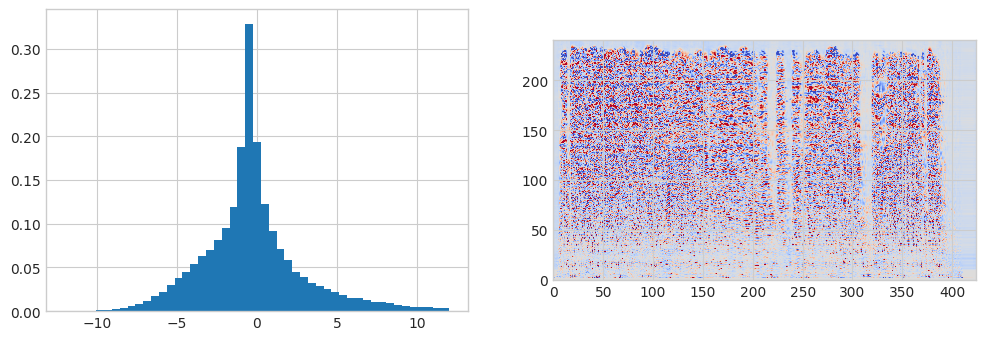

In [8]:
model2.to('cpu')
model.eval()

plt.plot(loss_hist[5:])
plt.show()

# _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), dpi=100)
# W = model.direct.weight.detach().numpy()
# print(np.min(W), np.max(W))
# ax1.imshow(W.T, origin='lower', cmap='coolwarm', vmin=-0.5, vmax=0.5)
# W = model.cbhg.fc.weight.detach().numpy()
# print(np.min(W), np.max(W))
# ax2.imshow(W, origin='lower', cmap='coolwarm', vmin=-0.25, vmax=0.25)
# plt.show()

transcript, D_db, M_db = dataset[2000]
print(transcript)
D_db = d_rev(d_fwd(D_db))
x = torch.from_numpy(m_fwd(M_db).T).unsqueeze(0)
y = model(x)
DD_db = d_rev(y.detach().numpy().squeeze(0).T)
print(DD_db.shape, D_db.shape, np.min(DD_db), np.max(DD_db))
print(f'std(err) = {np.std((DD_db - D_db).flatten()):.2f} dB')
print(f'mu(abs(err)) = {np.mean(np.abs(DD_db - D_db).flatten()):.2f} dB')

plt.plot(np.abs(DD_db - D_db).mean(axis=1))

# plt.figure(figsize=(12,4), dpi=100)
# plt.imshow(y[1].detach().numpy().squeeze(0).T, origin='lower', cmap='coolwarm')
# plt.show()
plt.figure(figsize=(12,5), dpi=100)
plt.imshow(M_db, origin='lower', cmap='coolwarm')
plt.show()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), dpi=100)
ax1.hist((DD_db - D_db).flatten(), bins=49, range=(-12, 12), density=True)
ax2.imshow(DD_db - D_db, origin='lower', cmap='coolwarm', vmin=-6, vmax=6)
plt.show()

audio, sr = audio_frontend.decode(D_db)
IPython.display.display(IPython.display.Audio(audio, rate=sr))
audio, sr = audio_frontend.decode(DD_db)
IPython.display.display(IPython.display.Audio(audio, rate=sr))
audio, sr = audio_frontend.decode(audio_frontend.mel_inv(M_db))
IPython.display.display(IPython.display.Audio(audio, rate=sr))